<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Redes-Neurais-OCT-Images/blob/main/TCC/OCT2017_dataset_Xception_classifier_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Métodos automatizados para detectar e classificar doenças humanas a partir de imagens médicas, utilizando aprendizado profundo 

Projeto de conclusão do curso BI-MASTER na PUC-RJ

Aluna: Renata Regina da Fonseca Santos

Orientadora: Professora Evelyn Conceição


## Objetivo

Utilização de modelos de inteligência artificial pré-treinados como alternativa para predição de diagnóstico em novos exames expostos aos modelos. Itens do trabalho:

*   Análise exploratória dos dados
*   Tratamento dos dados para uso na rede neural
*   Investigar as melhores opções de configuração para o caso proposto


## Descrição dos dados

O dataset é composto por imagens de Tomografia de Coerência Óptica da Retina (OCT), técnica de imagem usada para capturar seções transversais de alta resolução das retinas. É organizado em 3 diretórios (train, test, val). Cada um desses diretórios contém subdiretórios para cada categoria de imagem (NORMAL, CNV, DME,DRUSEN). São 84,495 imagens (JPEG) e 4 categorias:

*   CNV (choroidal neovascularization) -  Processo patológico que consiste da formação de novos vasos sanguíneos na COROIDE.

*   DME (diabetic macular edema) - Ao longo do tempo, níveis glicêmicos altos podem levar a complicações vasculares em vários tecidos e órgãos, como no coração, sistema nervoso, rins, membros inferiores (pernas e pés) e inclusive nos olhos.

*   DRUSEN - pequenos depósitos amarelos ou brancos na retina do olho ou na cabeça do nervo óptico. A presença de drusas é um dos sinais precoces mais comuns de degeneração macular relacionada à idade.

*   NORMAL



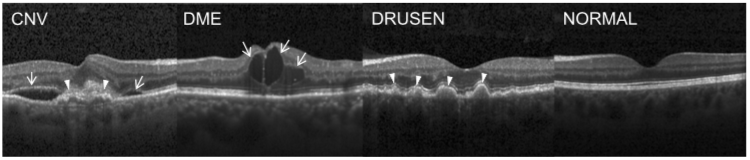

Labeled Optical Coherence Tomography (OCT) Images for Classification - Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2





## Importação das Bibliotecas

Este trabalho baseou-se na API Keras para a construção da rede neural para inferência dos diagnósticos.

https://keras.io

In [1]:
### Keras ###

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### Demais Bibliotecas ###
import pandas as pd
import numpy as np
import shutil
import random
from imutils import paths
import os
import cv2
import glob
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore")
np.random.seed(0)

## Download da base do Kaggle

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"renatarfsantos","key":"1401c3f022bf52f986b9ee0943db5879"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content/

100% 10.8G/10.8G [02:02<00:00, 55.4MB/s]
100% 10.8G/10.8G [02:02<00:00, 94.7MB/s]


In [6]:
!unzip -o -q /content/kermany2018.zip

## Separação da base em treino, teste e validação

As imagens nos diretórios train / val / test originais estavam repetidas, foi preciso fazer nova separação

In [7]:
dataset_path = '/content/OCT2017 /train/'
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [8]:
# Criar novos diretórios train / val / test (One time use)

val_ratio = 0.25
test_ratio = 0.10

for cls in classes:

  os.makedirs(dataset_path +'train/' + cls)
  os.makedirs(dataset_path +'val/' + cls)
  os.makedirs(dataset_path +'test/' + cls)

  # Creating partitions of the data after shuffeling
  src = dataset_path + cls # Folder to copy images from

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
  test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]


  print('Total images '+ cls + ':', len(allFileNames))
  print('Training '+ cls + ':', len(train_FileNames))
  print('Validation '+ cls + ':', len(val_FileNames))
  print('Testing '+ cls + ':', len(test_FileNames))
  
  # Copy-pasting images
  
  for name in train_FileNames:
    shutil.copy(name, dataset_path +'train/' + cls)

  for name in val_FileNames:
    shutil.copy(name, dataset_path +'val/' + cls)

  for name in test_FileNames:
    shutil.copy(name, dataset_path +'test/' + cls)                                              

Total images CNV: 37205
Training CNV: 24183
Validation CNV: 9301
Testing CNV: 3721
Total images DME: 11348
Training DME: 7376
Validation DME: 2837
Testing DME: 1135
Total images DRUSEN: 8616
Training DRUSEN: 5600
Validation DRUSEN: 2154
Testing DRUSEN: 862
Total images NORMAL: 26315
Training NORMAL: 17104
Validation NORMAL: 6579
Testing NORMAL: 2632


## Análise Exploratória

### Visualização de 4 imagens de cada classe do dataset

In [9]:
dataset_path = '/content/OCT2017 /train/train/'
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

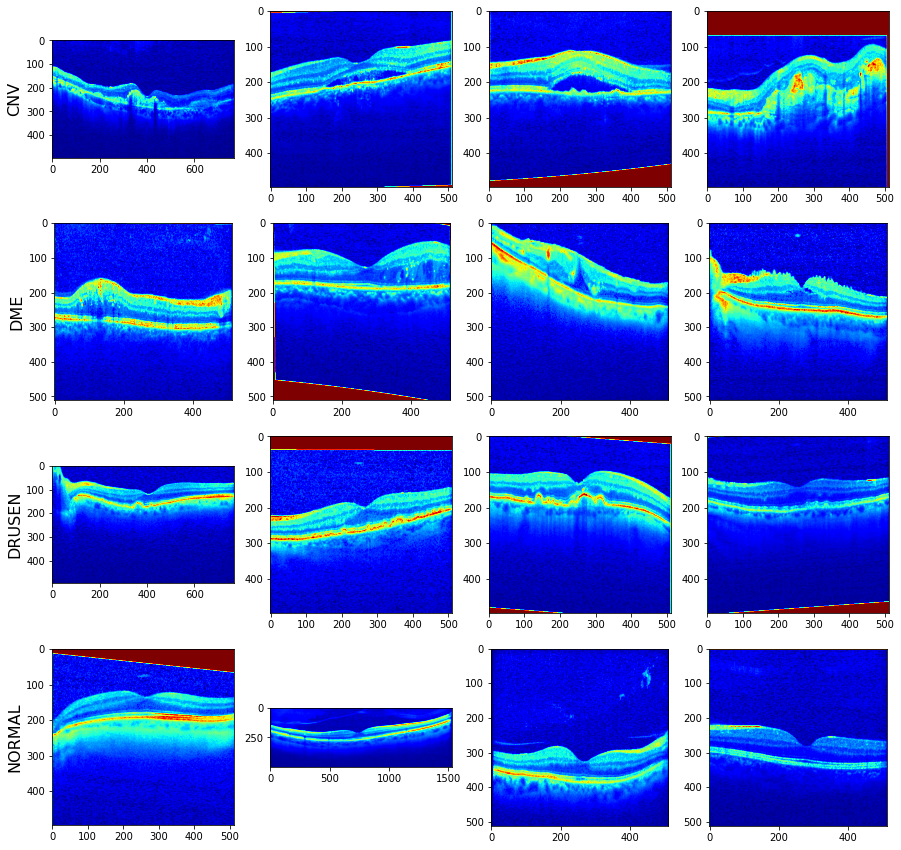

In [10]:
cnv_examples = glob.glob(dataset_path + 'CNV/*')
dme_examples = glob.glob(dataset_path + 'DME/*')
drusen_examples = glob.glob(dataset_path + 'DRUSEN/*')
normal_examples = glob.glob(dataset_path + 'NORMAL/*')

examples = cnv_examples[:4] + dme_examples[:4] + drusen_examples[:4] + normal_examples[:4]

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(columns*rows):
    img = plt.imread(examples[i])
    ax = fig.add_subplot(rows, columns, i+1)
    if i%4==0:
        plt.ylabel(classes[int(i/4)], fontsize=16)
    plt.imshow(img, cmap='jet')
plt.show()      

### Verificação do balanceamento da base está desbalanceada

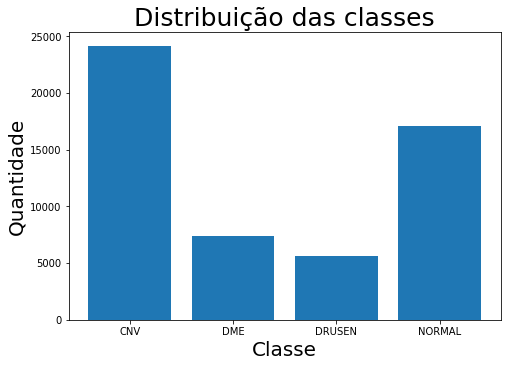

In [11]:
total_cnv_samples = len(glob.glob(dataset_path + 'CNV/*'))
total_dme_samples = len(glob.glob(dataset_path + 'DME/*'))
total_drusen_samples = len(glob.glob(dataset_path + 'DRUSEN/*'))
total_normal_samples = len(glob.glob(dataset_path + 'NORMAL/*'))

sample_distribution = [total_cnv_samples, total_dme_samples, total_drusen_samples, total_normal_samples]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution)
plt.xlabel("Classe", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
#fig.set_size_inches( 25, 8)
plt.title("Distribuição das classes", fontsize=25) 
plt.show();

## Pré-Processamento - Tratamento dos dados para uso na rede neural

### Data Augmentation

##### Aumenta a quantidade de dados, adicionando cópias ligeiramente modificadas de dados já existentes ou dados sintéticos recém-criados a partir de dados existentes

In [12]:
trainDataDir = '/content/OCT2017 /train/train'
validationDataDir = '/content/OCT2017 /train/val'
testDataDir = '/content/OCT2017 /test'

In [13]:
batchSize = 64

In [14]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=9,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest'
                                  )

trainGenerator = trainDataGen.flow_from_directory(trainDataDir,
                                                  target_size=(299, 299),   ## O tamanho padrão da imagem de entrada para a rede neural Xception é 299 x 299
                                                  batch_size=batchSize,
                                                  class_mode='categorical',
                                                  shuffle = True
                                                 )

validationDataGen = ImageDataGenerator(rescale=1./255
                                      )

validationGenerator = validationDataGen.flow_from_directory(validationDataDir,
                                                            target_size=(299, 299),   ## O tamanho padrão da imagem de entrada para a rede neural Xception é 299 x 299
                                                            batch_size=batchSize,
                                                            class_mode='categorical',
                                                            )

Found 54263 images belonging to 4 classes.
Found 20871 images belonging to 4 classes.


### Balanceamento do dataset - Removido do treinamento da rede neural, pois diminuiu a performance do modelo com os dados de teste

##### Não aumenta as amostras, mas atribui pesos a cada classe para evitar qualquer viés por meio de dados não balanceados (class_weights), os pesos são passados para o model.fit

In [15]:
#counter = Counter(trainGenerator.classes)                         
#max_val = float(max(counter.values()))  
#class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

#weights = np.fromiter(class_weights.values(), dtype=float)
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#ax.bar(classes, sample_distribution*weights) # Distribuição das classes com o ajuste dos pesos (class_weights)
#plt.show()

## Construção da rede neural Xception pré-treinada utilizando a base de dados "imageNet"

https://keras.io/api/applications/xception/

https://arxiv.org/abs/1610.02357

83697664/83683744 [==============================] - 1s 0us/step


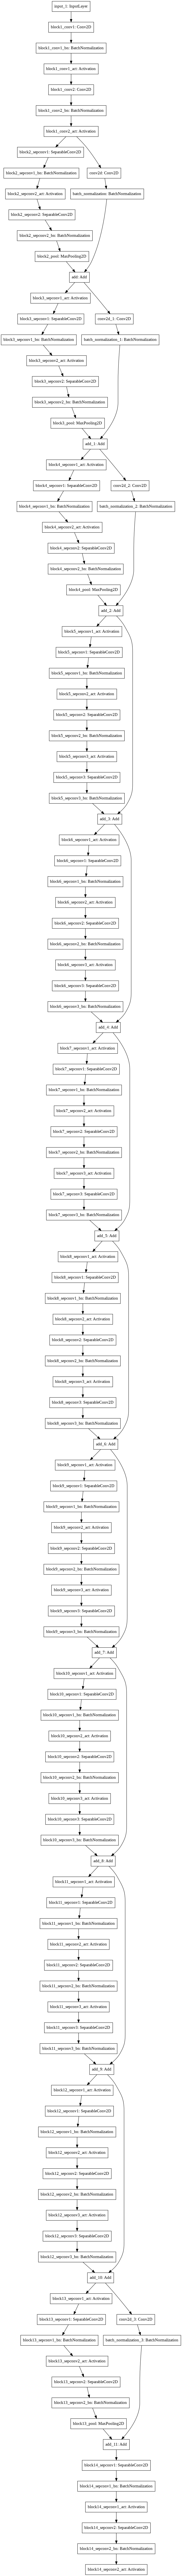

In [16]:
# Carregar a rede Xception certificando-se de que as camadas principais Full Connected (FC) sejam deixadas de fora

baseModel = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))

# Congela todas as camadas do modelo para que * não * sejam atualizadas durante o primeiro processo de treinamento
for layer in baseModel.layers:
    layer.trainable = False

plot_model(baseModel)

In [17]:
init_lr = 0.045
epochs = 30
num_classes = len(classes)

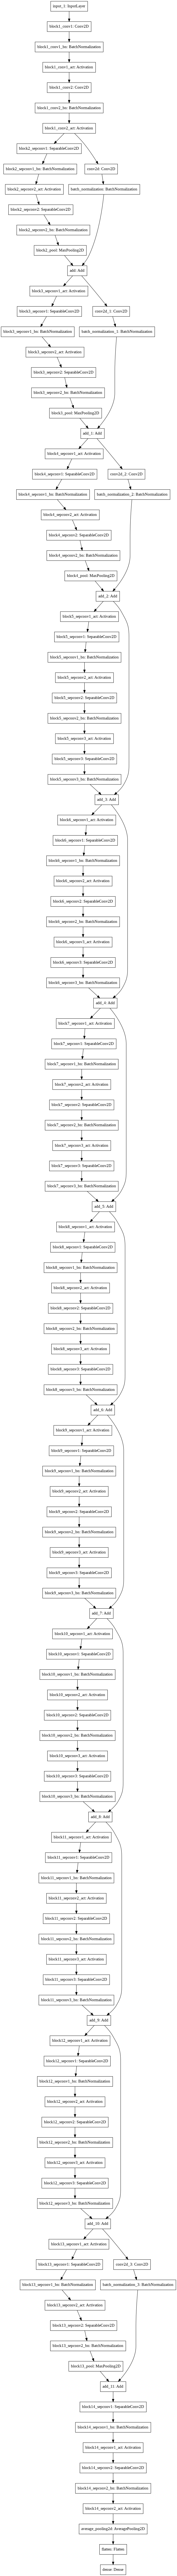

In [18]:
# Construir as camadas Full Connected (FC) "top" do modelo, que substituirão a base da Xception

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

# Construir o modelo CNN
model = Model(inputs=baseModel.input, outputs=headModel)

# Compilar o modelo
opt = SGD(lr=init_lr, decay=init_lr / epochs, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])

plot_model(model)

### Callbacks

In [19]:
es = EarlyStopping(patience=5, monitor="val_loss", mode='auto', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
mc = ModelCheckpoint(filepath='best.h5', save_best_only=True)

### Treinamento

In [20]:
# Treinamento
stepsValidation = validationGenerator.samples // batchSize
stepsTraining = trainGenerator.samples // batchSize

history = model.fit(trainGenerator,
    steps_per_epoch = stepsTraining,
    epochs=epochs,
    validation_data = validationGenerator,
    validation_steps = stepsValidation,
    callbacks=[es,rlr,mc]
)

#class_weight=class_weights,

Epoch 1/30
847/847 [==============================] - 1472s 2s/step - loss: 1.1872 - categorical_accuracy: 0.7688 - val_loss: 0.5809 - val_categorical_accuracy: 0.8569
Epoch 2/30
847/847 [==============================] - 1415s 2s/step - loss: 0.6150 - categorical_accuracy: 0.8225 - val_loss: 0.4530 - val_categorical_accuracy: 0.8672
Epoch 3/30
847/847 [==============================] - 1367s 2s/step - loss: 0.5201 - categorical_accuracy: 0.8357 - val_loss: 0.3938 - val_categorical_accuracy: 0.8750
Epoch 4/30
847/847 [==============================] - 1356s 2s/step - loss: 0.4564 - categorical_accuracy: 0.8447 - val_loss: 0.3910 - val_categorical_accuracy: 0.8692
Epoch 5/30
847/847 [==============================] - 1371s 2s/step - loss: 0.4290 - categorical_accuracy: 0.8507 - val_loss: 0.3658 - val_categorical_accuracy: 0.8785
Epoch 6/30
847/847 [==============================] - 1348s 2s/step - loss: 0.4149 - categorical_accuracy: 0.8562 - val_loss: 0.3660 - val_categorical_accuracy:

## Avaliação do Modelo

### Avaliação do histórico de treinamento do Modelo

Representação gráfica da precisão do treinamento versus perda, para melhor compreensão do treinamento do modelo

In [21]:
val_categorical_accuracy_median = history.history['val_categorical_accuracy'][len(history.history['val_categorical_accuracy'])//2]
print('val_categorical_accuracy: ', val_categorical_accuracy_median*100, '%')

val_categorical_accuracy:  88.42024803161621 %


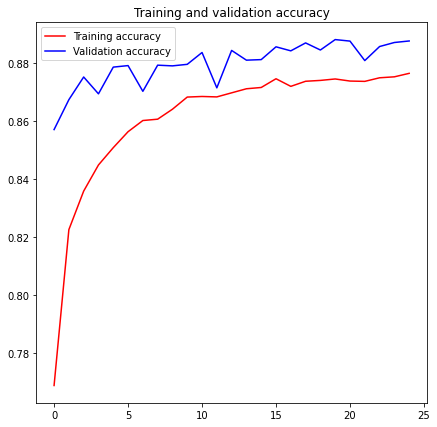

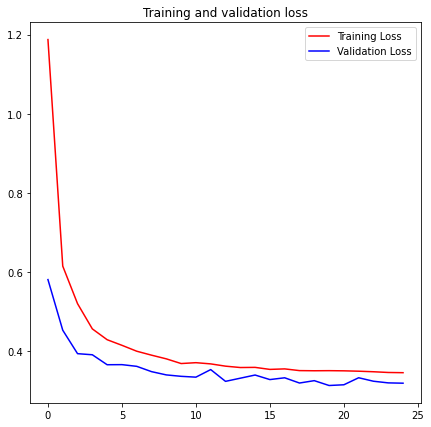

In [22]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = range(len(acc))

plt.figure(figsize=(7,7))

plt.plot(num_epochs, acc, 'r', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(7,7))

plt.plot(num_epochs, loss, 'r', label='Training Loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

### Avaliação do modelo utilizando a base de teste

In [23]:
test_images_path = glob.glob(testDataDir + '/*/*.jpeg')
x_test = []
y_test = []
for i in range(len(test_images_path)):
    img = cv2.imread(test_images_path[i])
    img = cv2.resize(img, (299,299))
    img = np.array(img/255.0)
    x_test.append(img)
    if 'CNV' in test_images_path[i]:
        y_test.append(0)
    elif 'DME' in test_images_path[i]:
        y_test.append(1)
    elif 'DRUSEN' in test_images_path[i]:
        y_test.append(2)
    elif 'NORMAL' in test_images_path[i]:
        y_test.append(3)
y_test = np.array(y_test)
x_test = np.array(x_test)
print(x_test.shape, y_test.shape)

(968, 299, 299, 3) (968,)


In [24]:
model.load_weights('best.h5') # carrega os pesos da melhor rede
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

labels = ('CNV', 'DME', 'DRUSEN', 'NORMAL')

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

df_conf_norm = df_confusion / df_confusion.sum(axis=1)

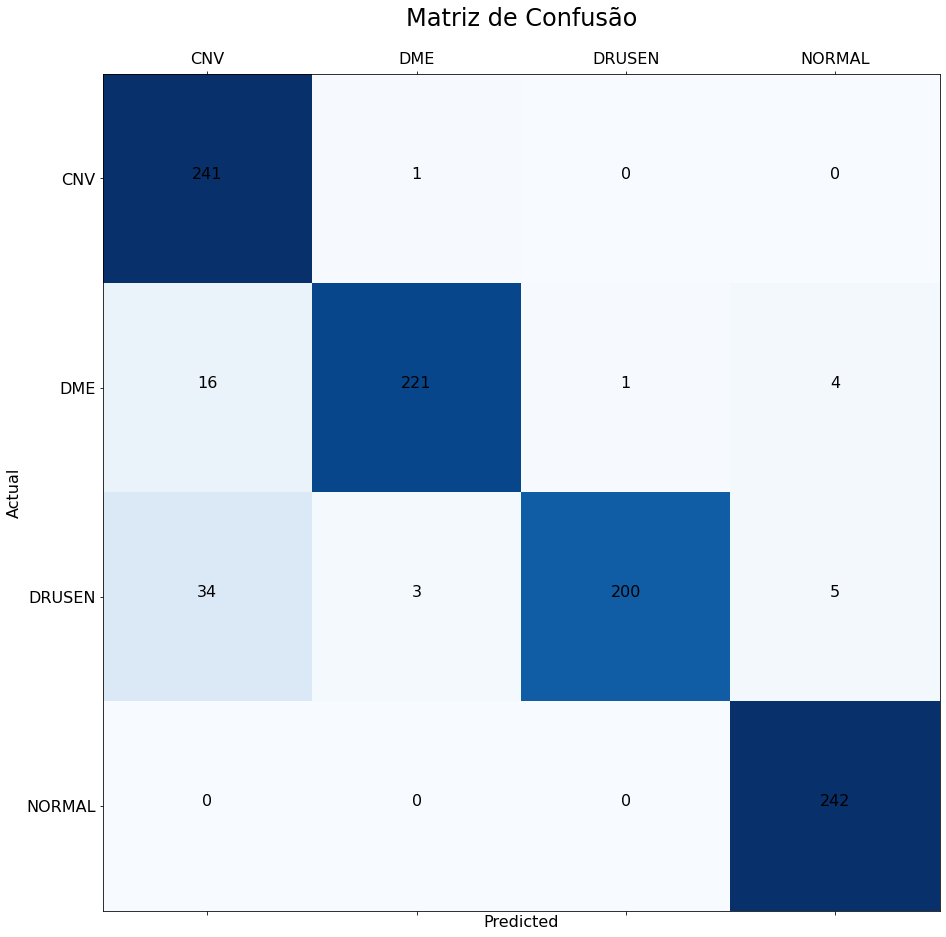

In [25]:
plt.figure(figsize=(15, 15))
plt.matshow(df_confusion, cmap=plt.get_cmap('Blues'), fignum=1)  # imshow
#plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels,fontsize=16)
plt.yticks(tick_marks, labels, fontsize=16)
thresh = 0.6

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, (df_confusion[i][j]),
                 horizontalalignment='center', fontsize = 16)

plt.tight_layout()
plt.title('Matriz de Confusão', fontsize=24)
plt.ylabel(df_confusion.index.name, fontsize=16)
plt.xlabel(df_confusion.columns.name,fontsize=16)
plt.show()

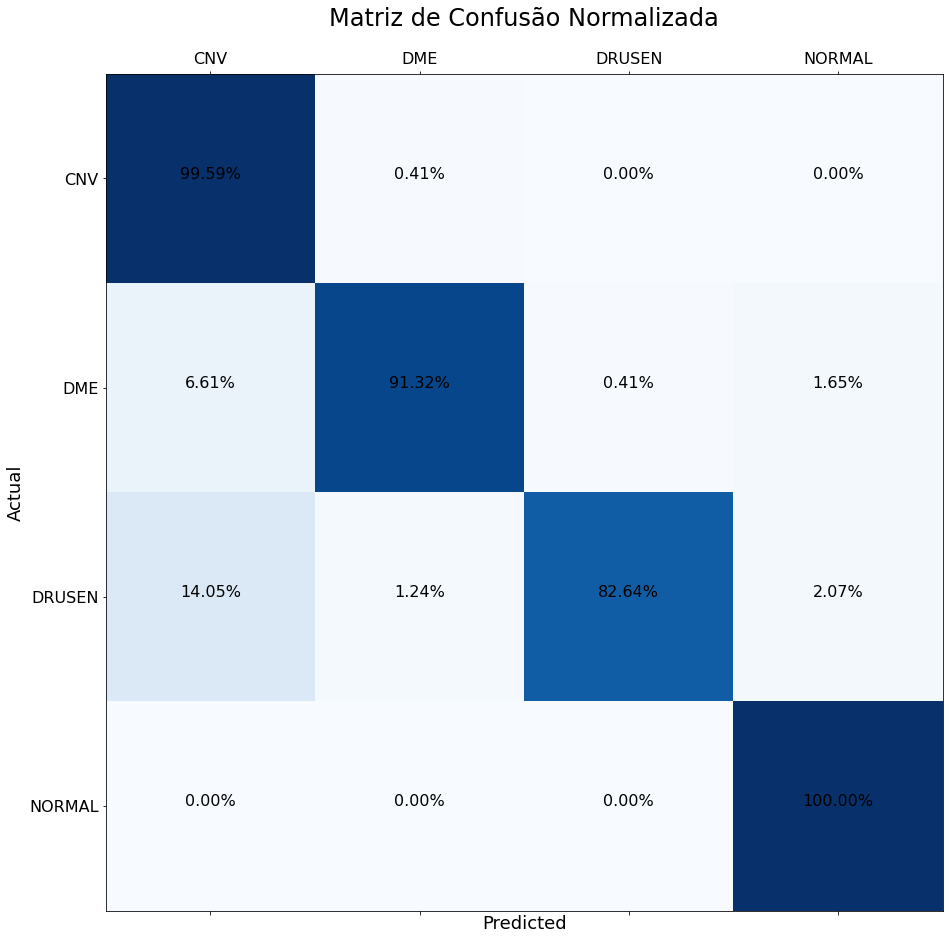

In [26]:
plt.figure(figsize=(15, 15))
plt.matshow(df_confusion, cmap=plt.get_cmap('Blues'), fignum=1)  # imshow
#plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels,fontsize=16)
plt.yticks(tick_marks, labels, fontsize=16)
thresh = 0.6

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, "{:0.2f}%".format(df_conf_norm[i][j] * 100),
                 horizontalalignment='center', fontsize = 16)

plt.tight_layout()
plt.title('Matriz de Confusão Normalizada', fontsize=24)
plt.ylabel(df_confusion.index.name, fontsize=18)
plt.xlabel(df_confusion.columns.name,fontsize=18)
plt.show()